Is classifying LLP events really that easy? Let's try to use a simple logistic regression classifier to see if we can get a good result without even using a NN.

In [1]:
import sys
import numpy as np

sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
_display_plot_rcParams = {
    'figure.figsize' : [10,7],
    'figure.dpi' : 100,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'xtick.minor.visible' : True,
    'ytick.right' : True,
    'ytick.direction' : 'in',
    'ytick.minor.visible' : True,
    'font.size' : 12,
    'mathtext.default' : 'regular',
    'font.family' : 'DejaVu Serif',
    }
plt.rcParams.update(_display_plot_rcParams)

In [11]:
base = "~/data/atlas/qcd_llp_datasets/"
qcd = base+"QCD_multijet_events_200k.root"
llp = [base+"500GeV_n3_events_100k.root", base+'100GeV_n3_events_100k.root']

# llp = '~/data/atlas/500GeV_n3_special_card.root'
# qcd = '~/data/atlas/QCD_jjj_bkg.root'

from models.utils import DVDataset

ds = DVDataset(llp, qcd, num=-1, read_in_memory=True, num_high_pt=15)

Take 15 highest PT tracks from each event to use for classification. Each event in each dataset has >=30 ish tracks, so there should be no padding needed.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ds.inputs, ds.labels,
                                                    test_size=0.2)

# tracks are ordered by pt low to high, so we can
# just take the first feature (pt) of the last track
X_train = X_train[:,-1,[0]].numpy()
X_test = X_test[:,-1,[0]].numpy()
y_train = y_train.ravel().numpy()
y_test = y_test.ravel().numpy()

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((312800, 1), (312800,)), ((78200, 1), (78200,)))

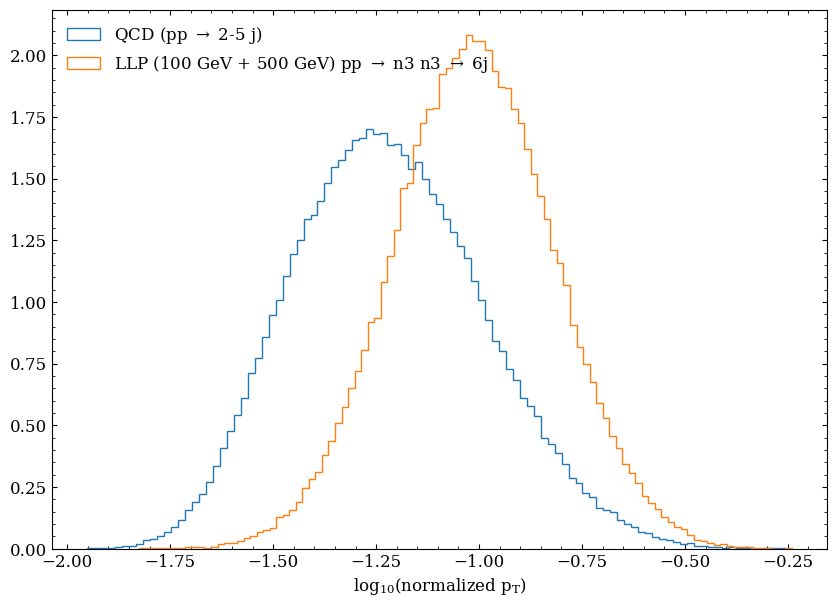

In [14]:
plt.hist(np.log10(X_train[y_train==0]), bins=100, histtype='step', label='QCD (pp $\\to$ 2-5 j)', density=True)
plt.hist(np.log10(X_train[y_train==1]), bins=100, histtype='step', label='LLP (100 GeV + 500 GeV) pp $\\to$ n3 n3 $\\to$ 6j', density=True)
plt.legend(loc='upper left', frameon=False)
plt.xlabel('$log_{10}($normalized $p_T)$')
plt.show()


In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(np.log10(X_train), y_train)

LogisticRegression(random_state=42)

In [16]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(np.log10(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# TPR
TPR = (y_test.astype(bool) & y_pred.astype(bool)).sum() / y_test.sum()
print(f"TPR: {TPR}")

Accuracy: 0.6891432225063938
TPR: 0.6987472252698186


/tmp/ipykernel_1599022/2393775705.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, tpr/np.sqrt(fpr), c='k', label='SIC')
/tmp/ipykernel_1599022/2393775705.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr, tpr/np.sqrt(fpr), c='k', label='SIC')


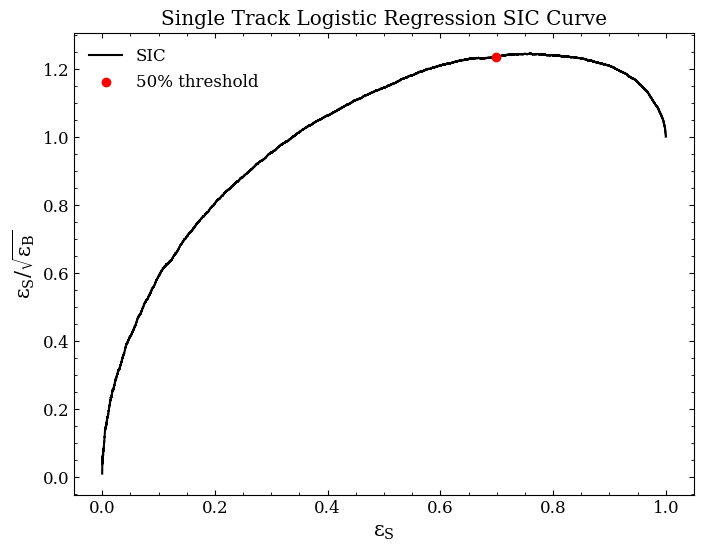

In [17]:
# plot ROC
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = model.predict_proba(np.log10(X_test))[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# get SIC at 50% threshold
plt.figure(figsize=(8,6))
plt.plot(tpr, tpr/np.sqrt(fpr), c='k', label='SIC')
idx = np.argmin(np.abs(thresholds-0.5))
plt.scatter(tpr[idx], tpr[idx]/np.sqrt(fpr[idx]), c='r', zorder=999,
            label='50% threshold')
plt.xlabel('$\\epsilon_S$', fontsize=15)
plt.ylabel('$\\epsilon_S/\\sqrt{\\epsilon_B}$', fontsize=15)
plt.title('Single Track Logistic Regression SIC Curve')
plt.legend(frameon=False)
plt.show()
